In [1]:
library(tidyverse)
library(openxlsx)
library(patchwork)
options(stringsAsFactors = F)
setwd("../../../../Fetal_metaQTL/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘openxlsx’ was built under R version 4.1.1”


# Functions

In [2]:
fisher_ORA <- function(test_set, test_background, ref_set, ref_background, verbose = FALSE) {
    overlap = length(intersect(test_set, ref_set)) #q
    group1 = length(intersect(test_set, ref_background)) #k
    group2 = length(intersect(ref_set, test_background)) #m
    total = length(intersect(test_background, ref_background)) #t
    
    mat <- matrix(c(
        overlap, group1,
        group2, total
    ), nrow=2)
    rownames(mat) <- c("inRef", "!inRef")
    colnames(mat) <- c("inTest", "!inTest")
    
    if (verbose) {
         print(mat)
    }
    
    fishers_df <- data.frame()
    fishers_df[1,1] <- overlap #q
    fishers_df[2,1] <- group2 - overlap #k-q
    fishers_df[1,2] <- group1 - overlap #m-q
    fishers_df[2,2] <- total - group2 - group1 + overlap #t-m-k+q

    res <- fisher.test(fishers_df, alternative='greater')
    return(res)
}

# Data Loading

In [3]:
# Load in fetal-specific eGenes and all discovered fetal eGenes
tableS1 <- readxl::read_xlsx("data/manuscript/ST1.xlsx", sheet="ST1-2-eGene")
fetal_only_eGenes <- tableS1 %>% filter(fetal_only=="yes") %>% select(pid, gene_name, gene_type, qval) %>% as_tibble()
fetal_all_eGenes <- tableS1 %>% select(pid) %>% pull()

head(fetal_only_eGenes)

length(fetal_all_eGenes)
dim(fetal_only_eGenes)

pid,gene_name,gene_type,qval
<chr>,<chr>,<chr>,<dbl>
ENSG00000000419,DPM1,protein_coding,0.00147123
ENSG00000002746,HECW1,protein_coding,0.00100023
ENSG00000004478,FKBP4,protein_coding,0.01215830
ENSG00000005812,FBXL3,protein_coding,0.04243070
ENSG00000006025,OSBPL7,protein_coding,0.02392810
ENSG00000006062,MAP3K14,protein_coding,0.01218350


[1] 10094

[1] 2488    4

In [4]:
# Load in cell type markers from fetal brain scRNAseq
# Poliodakis et al. subcluster analysis (Table S5)
celltypemarkers_tableS5 <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
celltypemarkers_tableS5 <- janitor::clean_names(celltypemarkers_tableS5)

# Use all cell markers as a background
celltypemarkers_tableS5_bg <- unique(celltypemarkers_tableS5$ensembl)

head(celltypemarkers_tableS5)
dim(celltypemarkers_tableS5)
unique(celltypemarkers_tableS5$subcluster)
length(celltypemarkers_tableS5_bg)

cluster,subcluster,gene,ensembl,log2_fold_change,pvalue,fdr,percent_cluster,percent_all
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
vRG,vRG_0,NPY,ENSG00000122585,0.942790163299949,2.57709368277351e-36,1.07928683434554e-32,51.8,24.8
vRG,vRG_0,LGALS3,ENSG00000131981,0.733201099417694,3.03296906500458e-32,4.2340248147464e-29,50,24.4
vRG,vRG_0,NNAT,ENSG00000053438,0.812606413056216,7.79412721754092e-19,6.52836095741227e-16,83,64.5
vRG,vRG_0,SLC1A2,ENSG00000110436,0.384165785170468,3.04015437301369e-17,1.59152081427267e-14,27.2,12.9
vRG,vRG_0,SLCO1C1,ENSG00000139155,0.360802531568306,3.99551060019108e-17,1.75033287840493e-14,27.2,13.1
vRG,vRG_0,KIF5C,ENSG00000168280,0.578180352908194,1.9842717843625e-16,7.55466384810012e-14,56.2,37.3


[1] 10604     9

[1] "vRG_0"   "vRG_1"   "vRG_2"   "vRG_3"   "oRG_0"   "oRG_1"   "oRG_2"  
 [8] "oRG_3"   "oRG_4"   "PgS_0"   "PgS_1"   "PgS_2"   "PgS_3"   "PgS_4"  
[15] "PgG2M_0" "PgG2M_1" "PgG2M_2" "PgG2M_3" "PgG2M_4" "IP_0"    "IP_1"   
[22] "IP_2"    "IP_3"    "ExN_0"   "ExN_1"   "ExN_2"   "ExN_4"   "ExN_5"  
[29] "ExN_6"   "ExN_7"   "ExM_0"   "ExM_2"   "ExM_3"   "ExM_4"   "ExM_5"  
[36] "ExM_6"   "ExM_7"   "ExM-U_0" "ExM-U_1" "ExM-U_2" "ExM-U_3" "ExM-U_4"
[43] "ExM-U_5" "ExDp1_0" "ExDp1_1" "ExDp1_2" "ExDp1_3" "ExDp2_1" "InMGE_0"
[50] "InMGE_1" "InMGE_2" "InMGE_3" "InMGE_4" "InMGE_6" "InMGE_7" "InCGE_0"
[57] "InCGE_1" "InCGE_2" "InCGE_3" "InCGE_4" "InCGE_5" "OPC_0"   "OPC_1"  
[64] "OPC_2"   "OPC_3"   "OPC_4"   "OPC_5"   "End_1"   "End_2"   "Per_0"  
[71] "Per_1"   "Per_2"

[1] 4074

# Analysis

## GO Term Enrichment with gprofiler2

In [5]:
# Run gene ontology on fetal-only eGenes
go_genes <- fetal_only_eGenes %>%
                select(pid) %>%
                pull

# Non-ordered GO query with custom background of all fetal eGenes
gostres <- gprofiler2::gost(query = go_genes,
                custom_bg = fetal_all_eGenes,
                domain_scope = "custom",
                organism = "hsapiens",
                ordered_query = FALSE,
                significant = TRUE)

# Highlight all the terms since there are only a few
quick_res <- gostres$result %>%
                select(source, p_value, term_id)

png 
  2

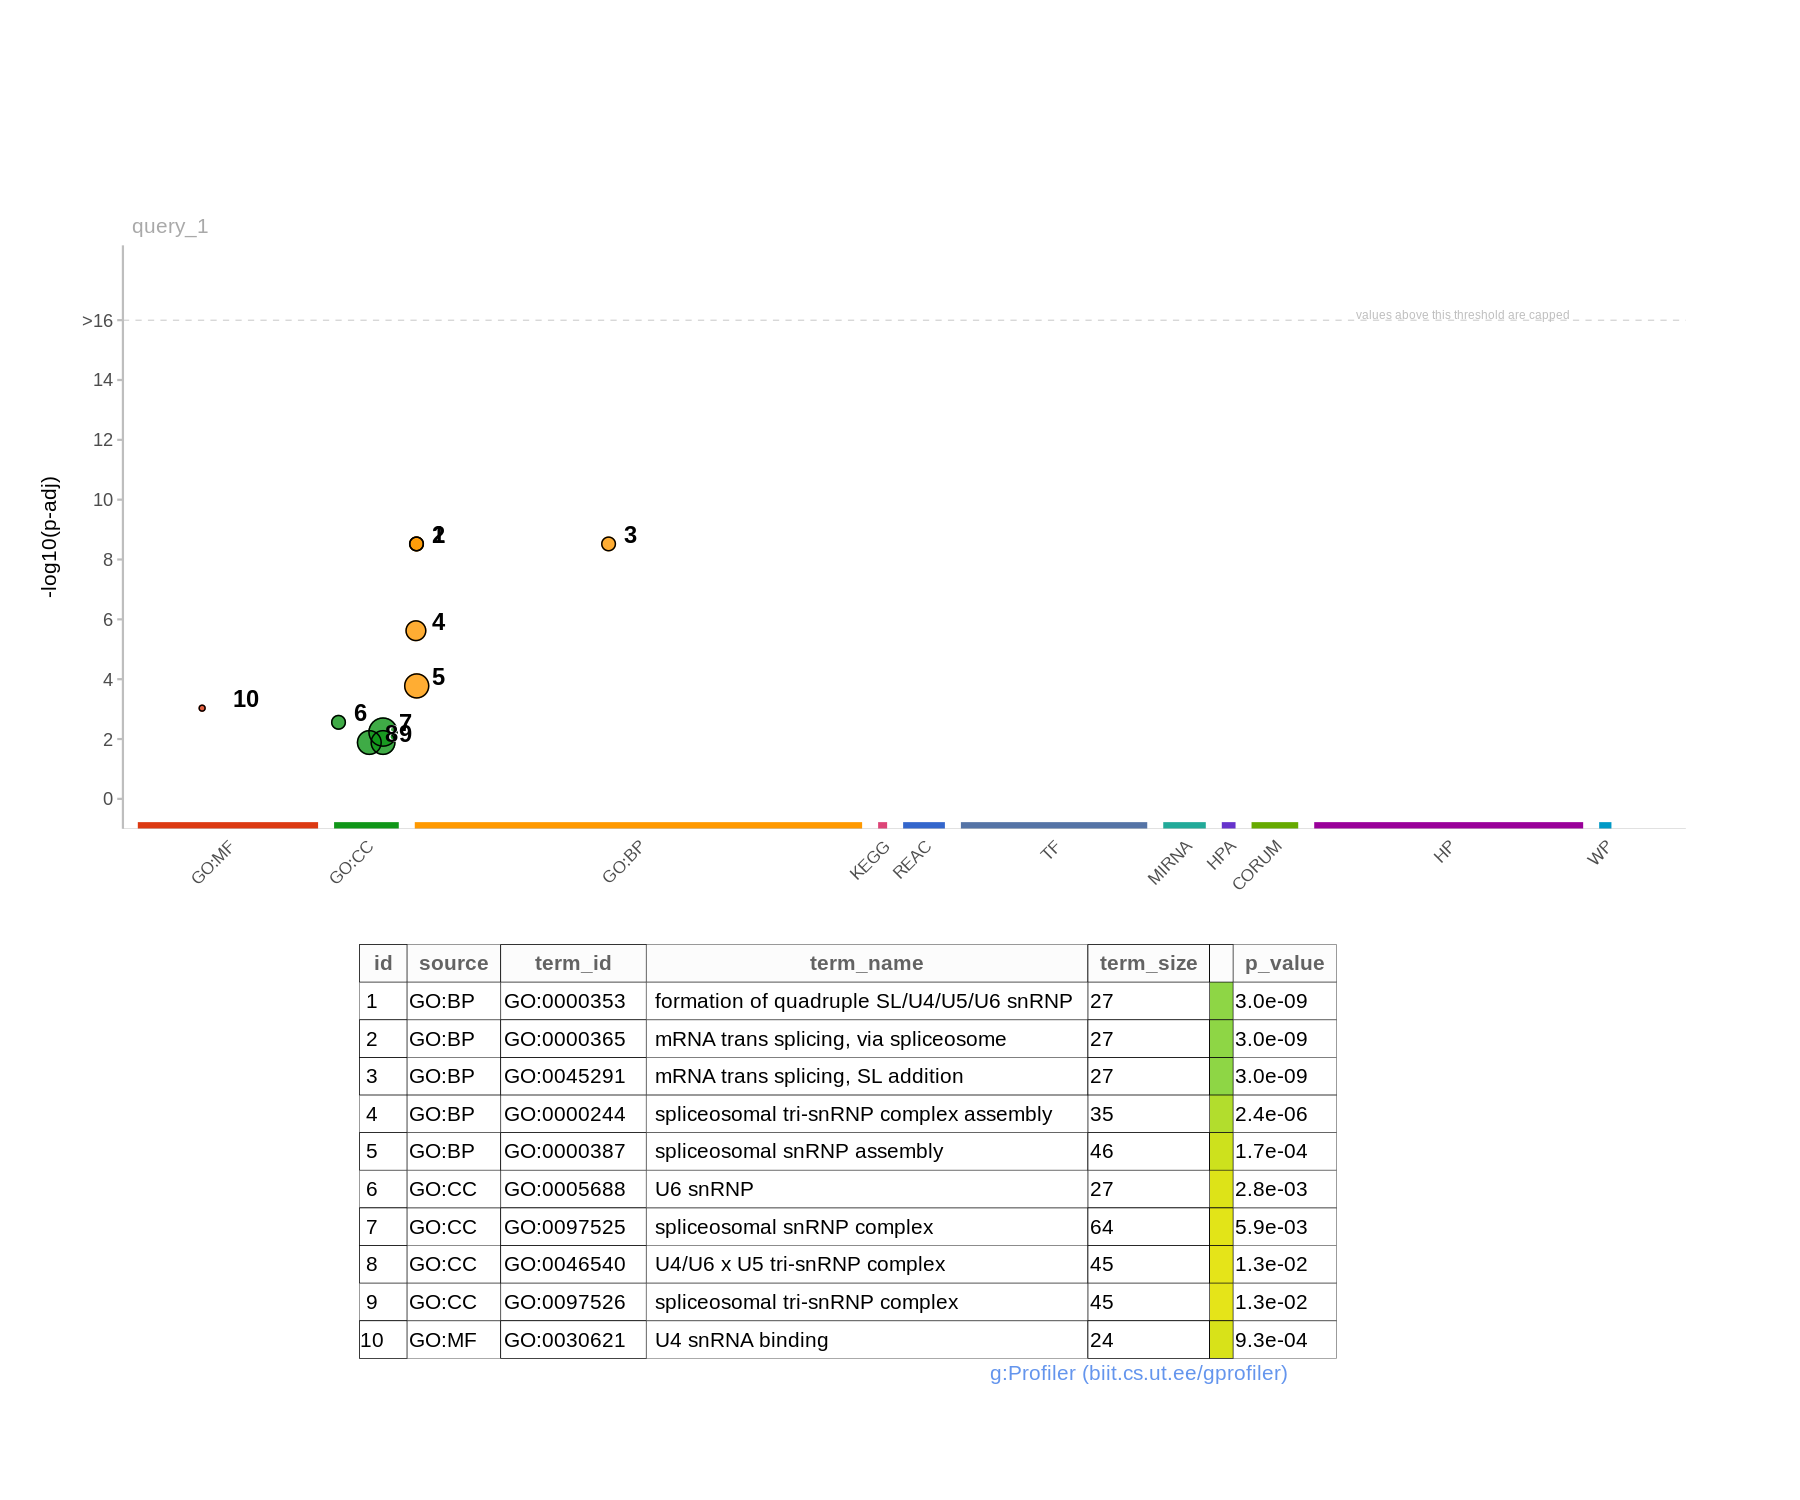

In [6]:
# Custom plot options
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)

# The gostplot function automatically plots the results, suppress that with file=NULL
pdf(file = NULL)
gplot <- gprofiler2::gostplot(gostres, capped = TRUE, interactive = FALSE)
pubplot <- gprofiler2::publish_gostplot(gplot, highlight_terms = quick_res$term_id) + theme(plot.margin = margin(t = 100, r = 50, b = 50, l = 0, unit = "pt"))
dev.off()

# Plot the results with highlights
pubplot

## Cell Marker Enrichment 

In [7]:
fetal_only_egenes_cell_subtype_res <- tibble()

for (cell in unique(celltypemarkers_tableS5$subcluster)) {
    cat(paste0(cell, " "))
    
    one_cell_markers <- celltypemarkers_tableS5 %>%
                            filter(subcluster == cell) %>%
                            select(ensembl) %>%
                            pull
    
    res <- fisher_ORA(test_set = fetal_only_eGenes$pid,
                       test_background = fetal_all_eGenes,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS5_bg)
    
    fetal_only_egenes_cell_subtype_res <- rbind(fetal_only_egenes_cell_subtype_res, tibble(scenario = "fetal_only_egenes",
                                                                                   cell_type = cell,
                                                                                   fisher_p = res$p.value,
                                                                                   fisher_or = as.numeric(res$estimate)))
}

fetal_only_egenes_cell_subtype_res %>% arrange(fisher_p) %>% head

vRG_0 vRG_1 vRG_2 vRG_3 oRG_0 oRG_1 oRG_2 oRG_3 oRG_4 PgS_0 PgS_1 PgS_2 PgS_3 PgS_4 PgG2M_0 PgG2M_1 PgG2M_2 PgG2M_3 PgG2M_4 IP_0 IP_1 IP_2 IP_3 ExN_0 ExN_1 ExN_2 ExN_4 ExN_5 ExN_6 ExN_7 ExM_0 ExM_2 ExM_3 ExM_4 ExM_5 ExM_6 ExM_7 ExM-U_0 ExM-U_1 ExM-U_2 ExM-U_3 ExM-U_4 ExM-U_5 ExDp1_0 ExDp1_1 ExDp1_2 ExDp1_3 ExDp2_1 InMGE_0 InMGE_1 InMGE_2 InMGE_3 InMGE_4 InMGE_6 InMGE_7 InCGE_0 InCGE_1 InCGE_2 InCGE_3 InCGE_4 InCGE_5 OPC_0 OPC_1 OPC_2 OPC_3 OPC_4 OPC_5 End_1 End_2 Per_0 Per_1 Per_2 

scenario,cell_type,fisher_p,fisher_or
<chr>,<chr>,<dbl>,<dbl>
fetal_only_egenes,vRG_0,0.001109042,3.293956
fetal_only_egenes,PgS_0,0.006811798,4.000788
fetal_only_egenes,ExN_1,0.027275602,3.680192
fetal_only_egenes,IP_1,0.038674920,2.124972
fetal_only_egenes,End_2,0.050597267,2.006989
fetal_only_egenes,PgS_3,0.051036457,1.625594


## Biotype Breakdown

In [8]:
fetal_only_biotype_df <- fetal_only_eGenes %>% count(gene_type) %>% filter(n > 10) %>% mutate(prop = n/sum(n))
fetal_only_biotype_df

gene_type,n,prop
<chr>,<int>,<dbl>
lncRNA,1069,0.435970636
miRNA,55,0.022430669
misc_RNA,67,0.027324633
processed_pseudogene,198,0.080750408
protein_coding,737,0.300570962
snoRNA,67,0.027324633
snRNA,35,0.014274062
TEC,103,0.042006525
transcribed_processed_pseudogene,24,0.009787928


# Manuscript Figures

## Figure S3 - Fetal Only eGene Enrichment

In [9]:
fetal_egene_plot_tbl <- fetal_only_egenes_cell_subtype_res %>%
                            mutate(fisher_fdr = p.adjust(fisher_p, "fdr")) %>%
                            mutate(fisher_fdr_log = -log10(fisher_fdr)) %>% 
                            arrange(cell_type) %>%
                            mutate(class = case_when(
                                grepl("Ex", cell_type) ~ "Excitatory Neurons",
                                grepl("In", cell_type) ~ "Interneurons",
                                grepl("Mic|Per|End", cell_type) ~ "Other",
                                TRUE ~ "Progenitors"
                            ))

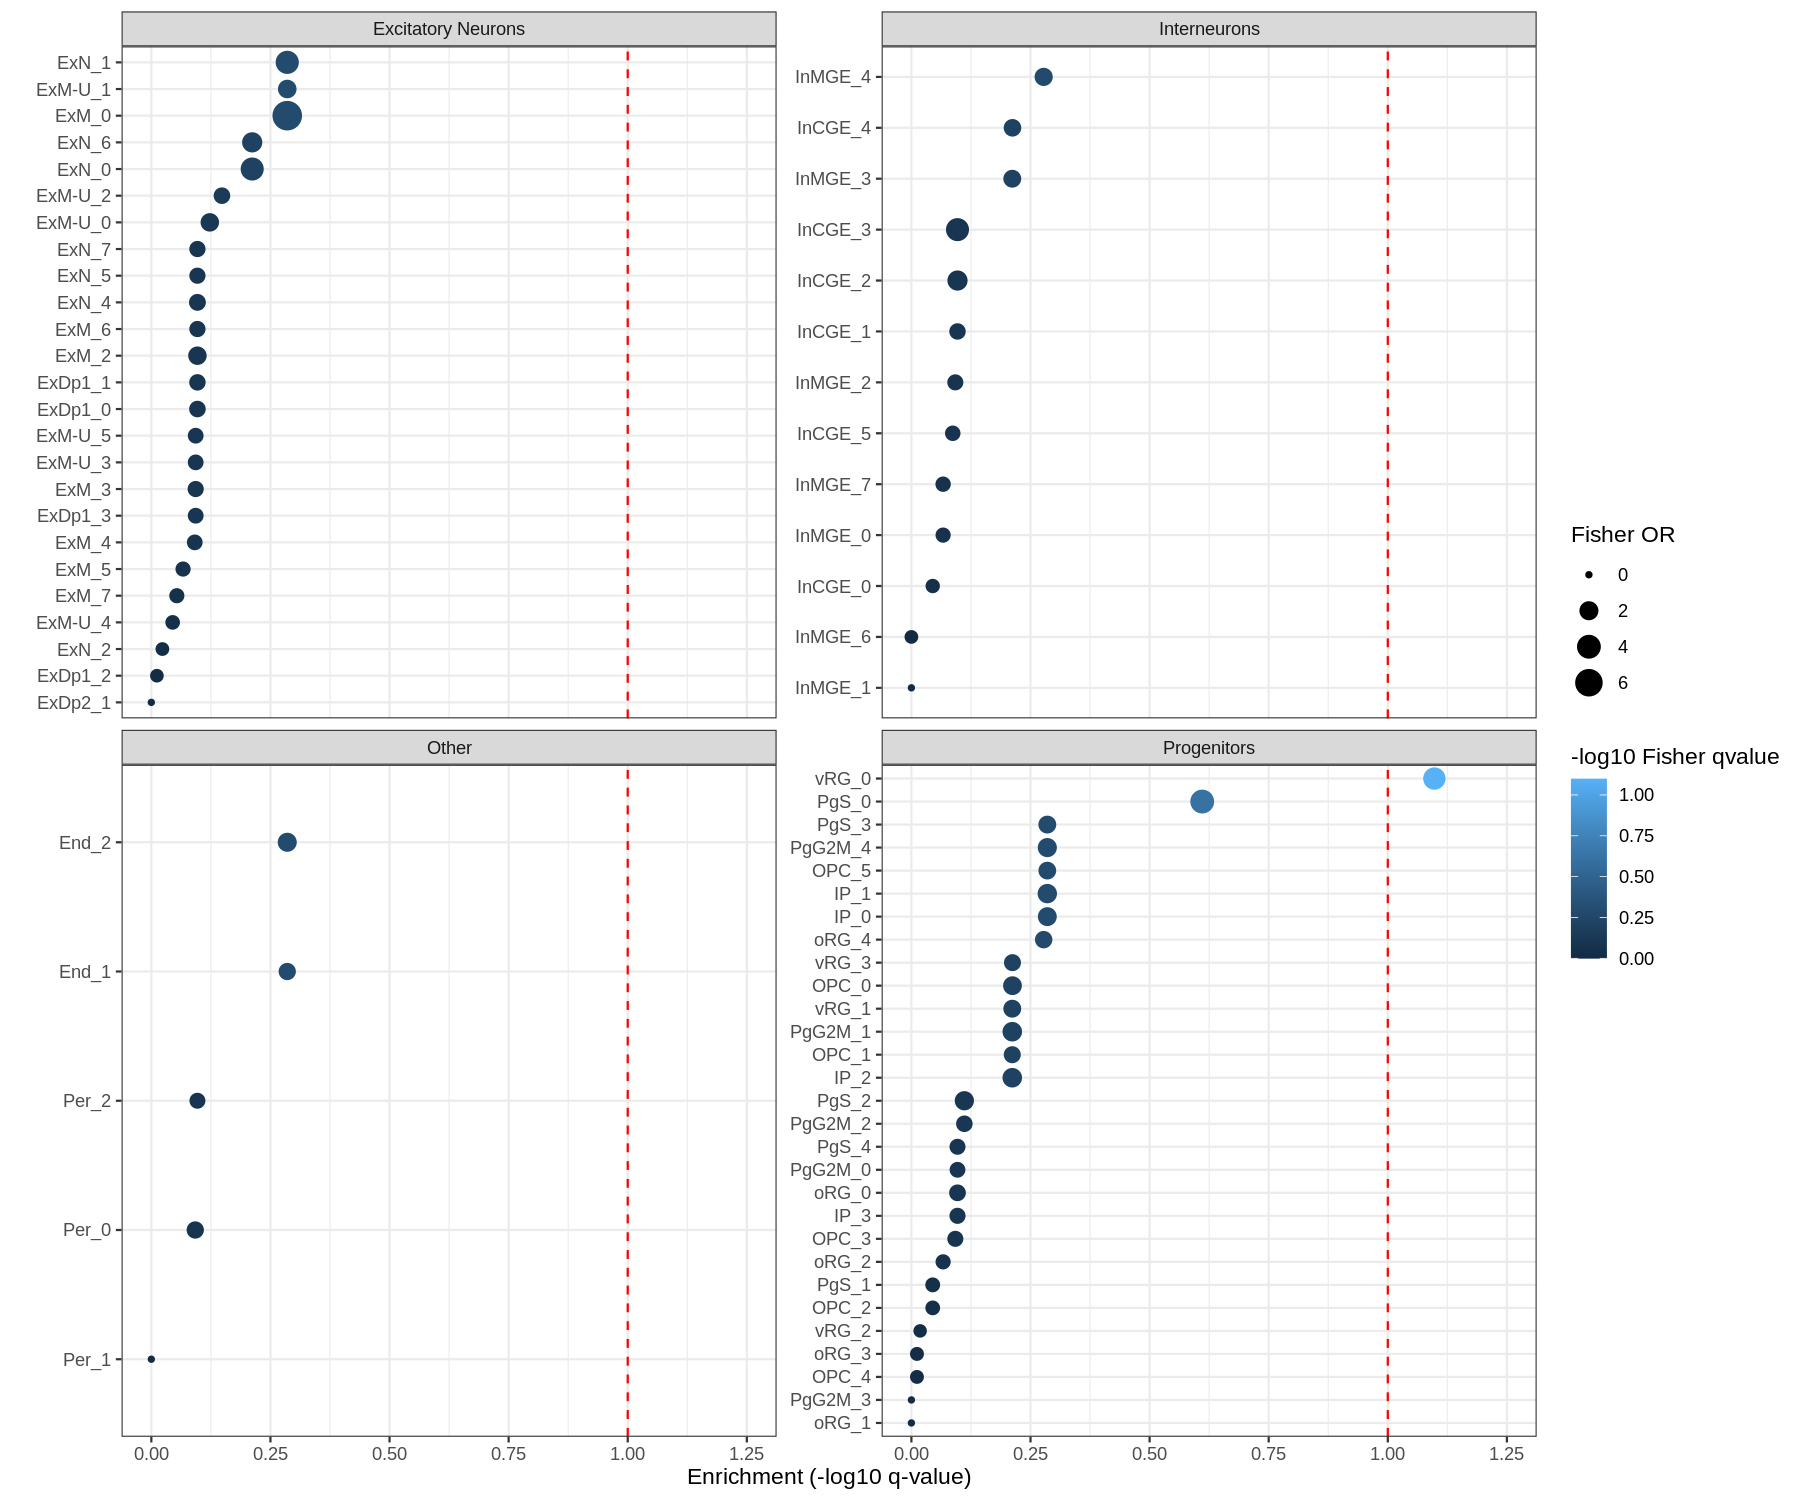

In [10]:
cell_plot <- ggplot(fetal_egene_plot_tbl, aes(
        x = reorder(cell_type, -fisher_fdr),
        y = -log10(fisher_fdr),
        size = fisher_or,
        color = -log10(fisher_fdr))) +
    geom_point() + coord_flip() + facet_wrap(~class, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = 1,lty=2,color='red') + labs(y='Enrichment (-log10 q-value)', x='') + 
    theme(plot.title = element_text(hjust=.5)) +
    labs(size = "Fisher OR", color = "-log10 Fisher qvalue") + scale_y_continuous(limits = c(0, 1.25), breaks = seq(0,1.25,0.25))

cell_plot

In [11]:
fetal_only_biotype_plot_df <- fetal_only_biotype_df %>%
                              mutate(gene_type = gsub("_", "\n", gene_type))

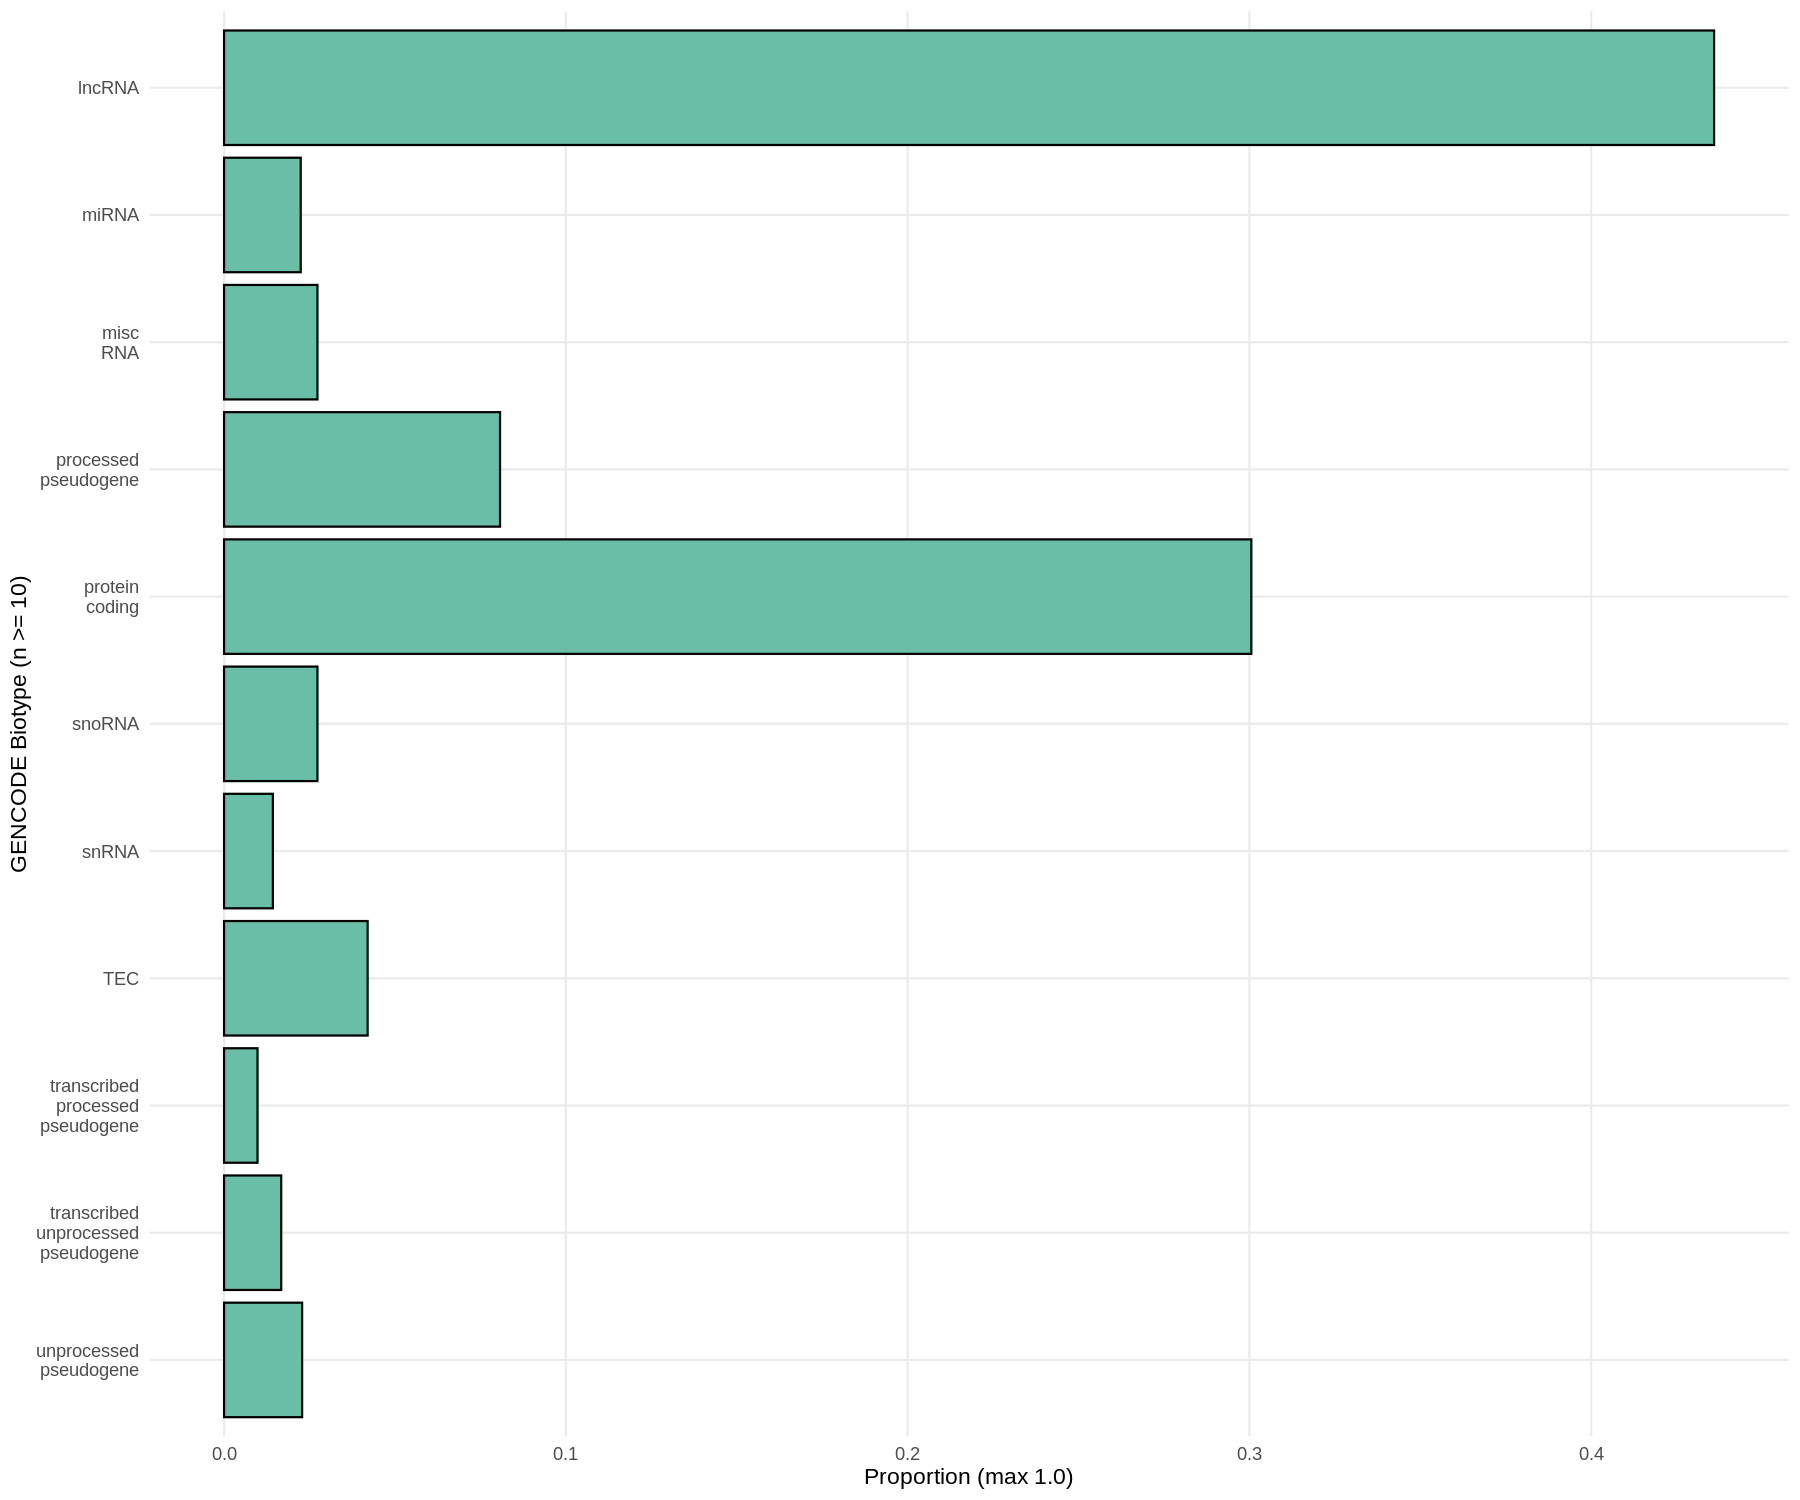

In [12]:
biotype_plot <- ggplot(data = fetal_only_biotype_plot_df, aes(x = prop, y = fct_rev(gene_type))) +
    geom_bar(stat="identity", color="black", position=position_dodge2(padding = 0, reverse = TRUE), fill = "#6ABEA7") +
    xlab("Proportion (max 1.0)") + ylab("GENCODE Biotype (n >= 10)") +
    theme_minimal() +
    theme(panel.grid.minor = element_blank(),
          panel.background = element_blank())

biotype_plot

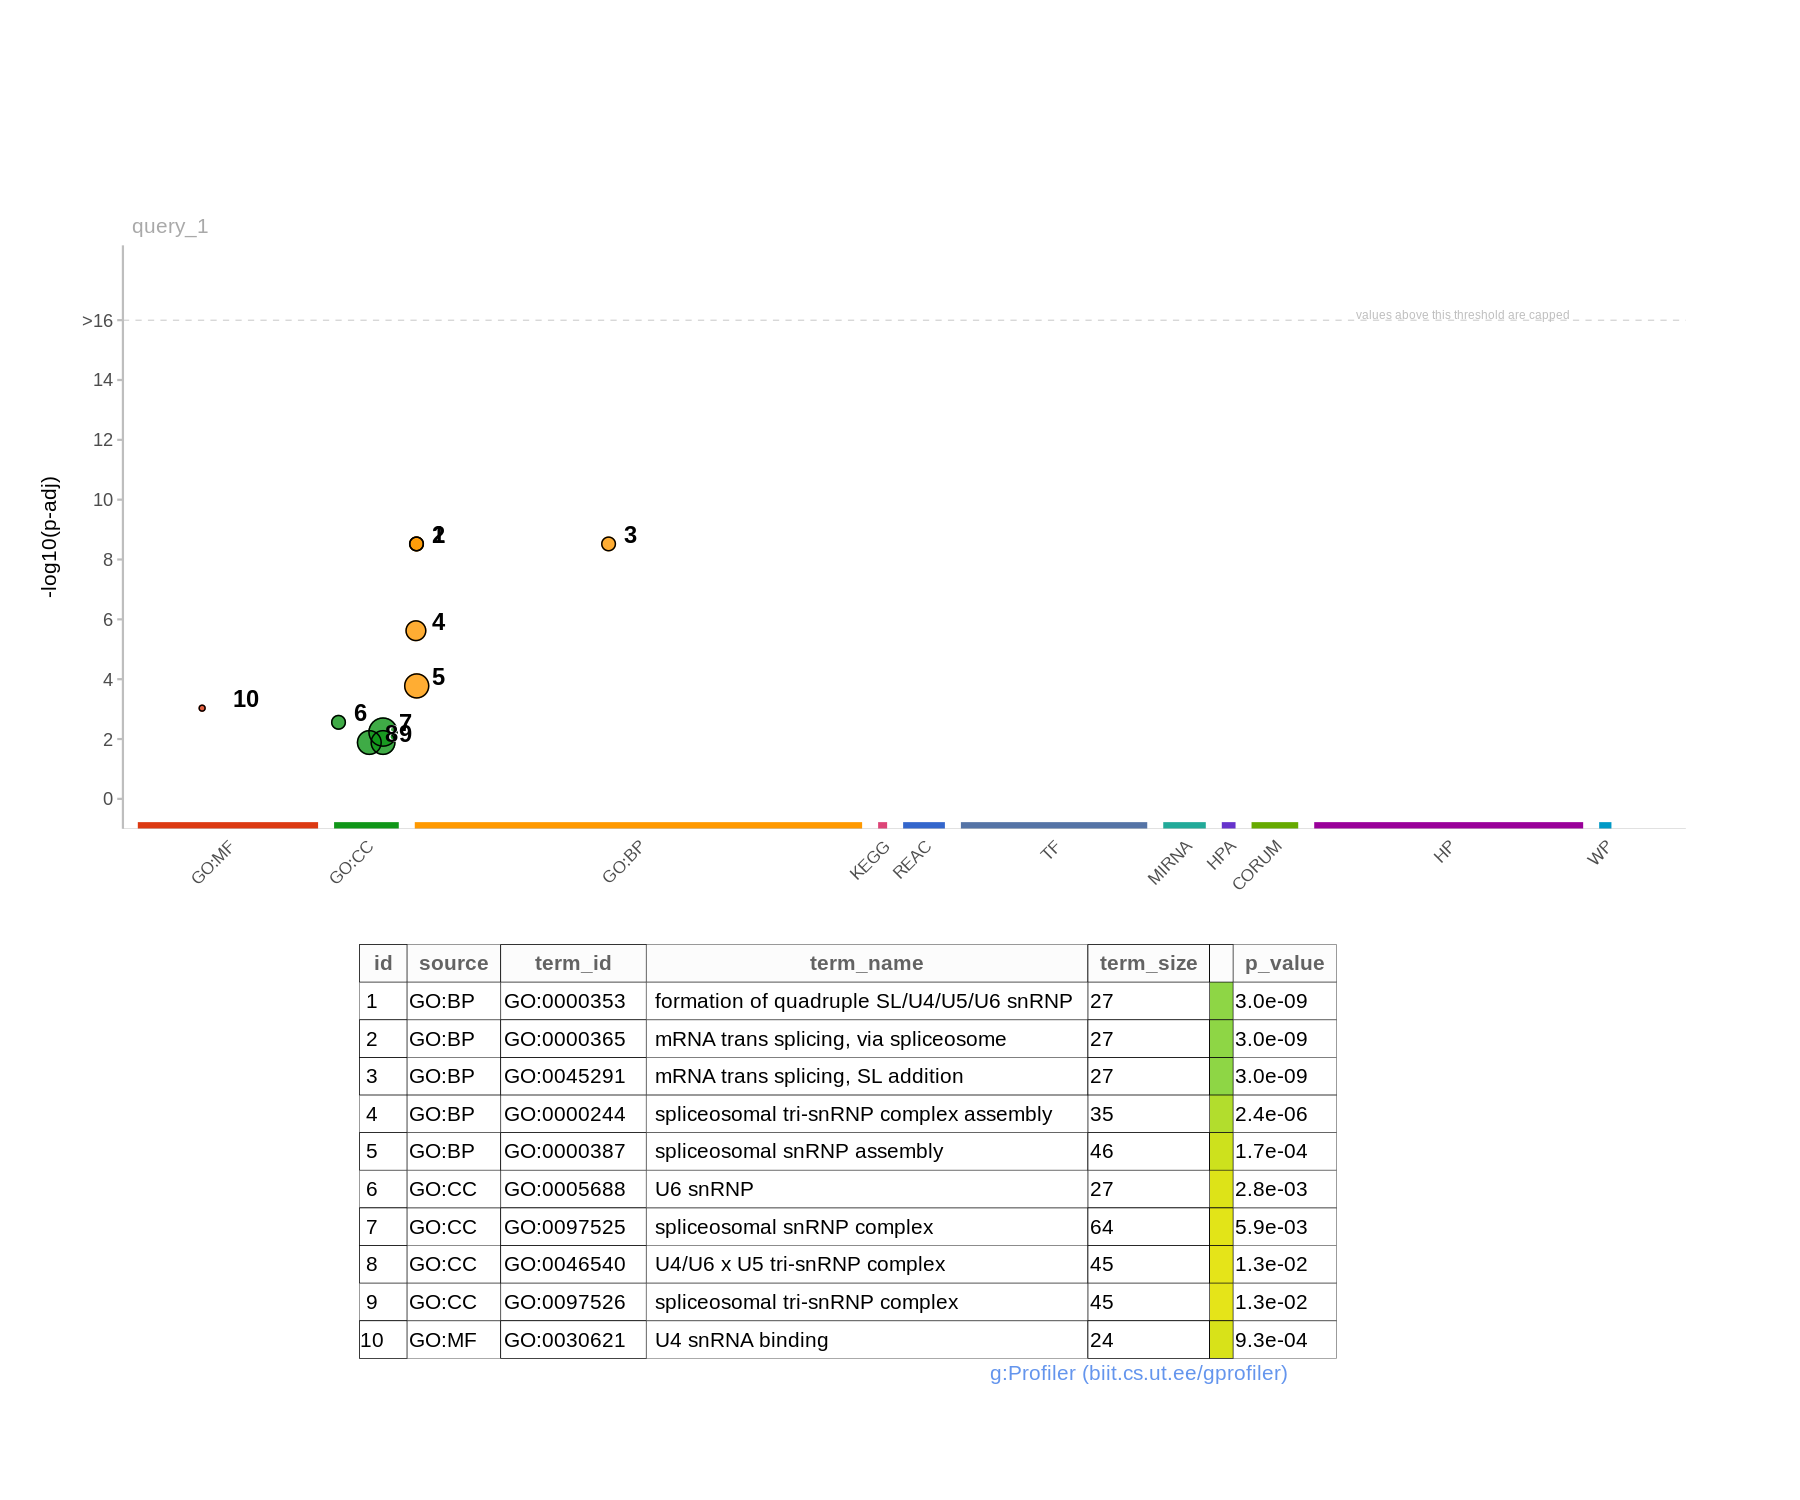

In [13]:
pubplot

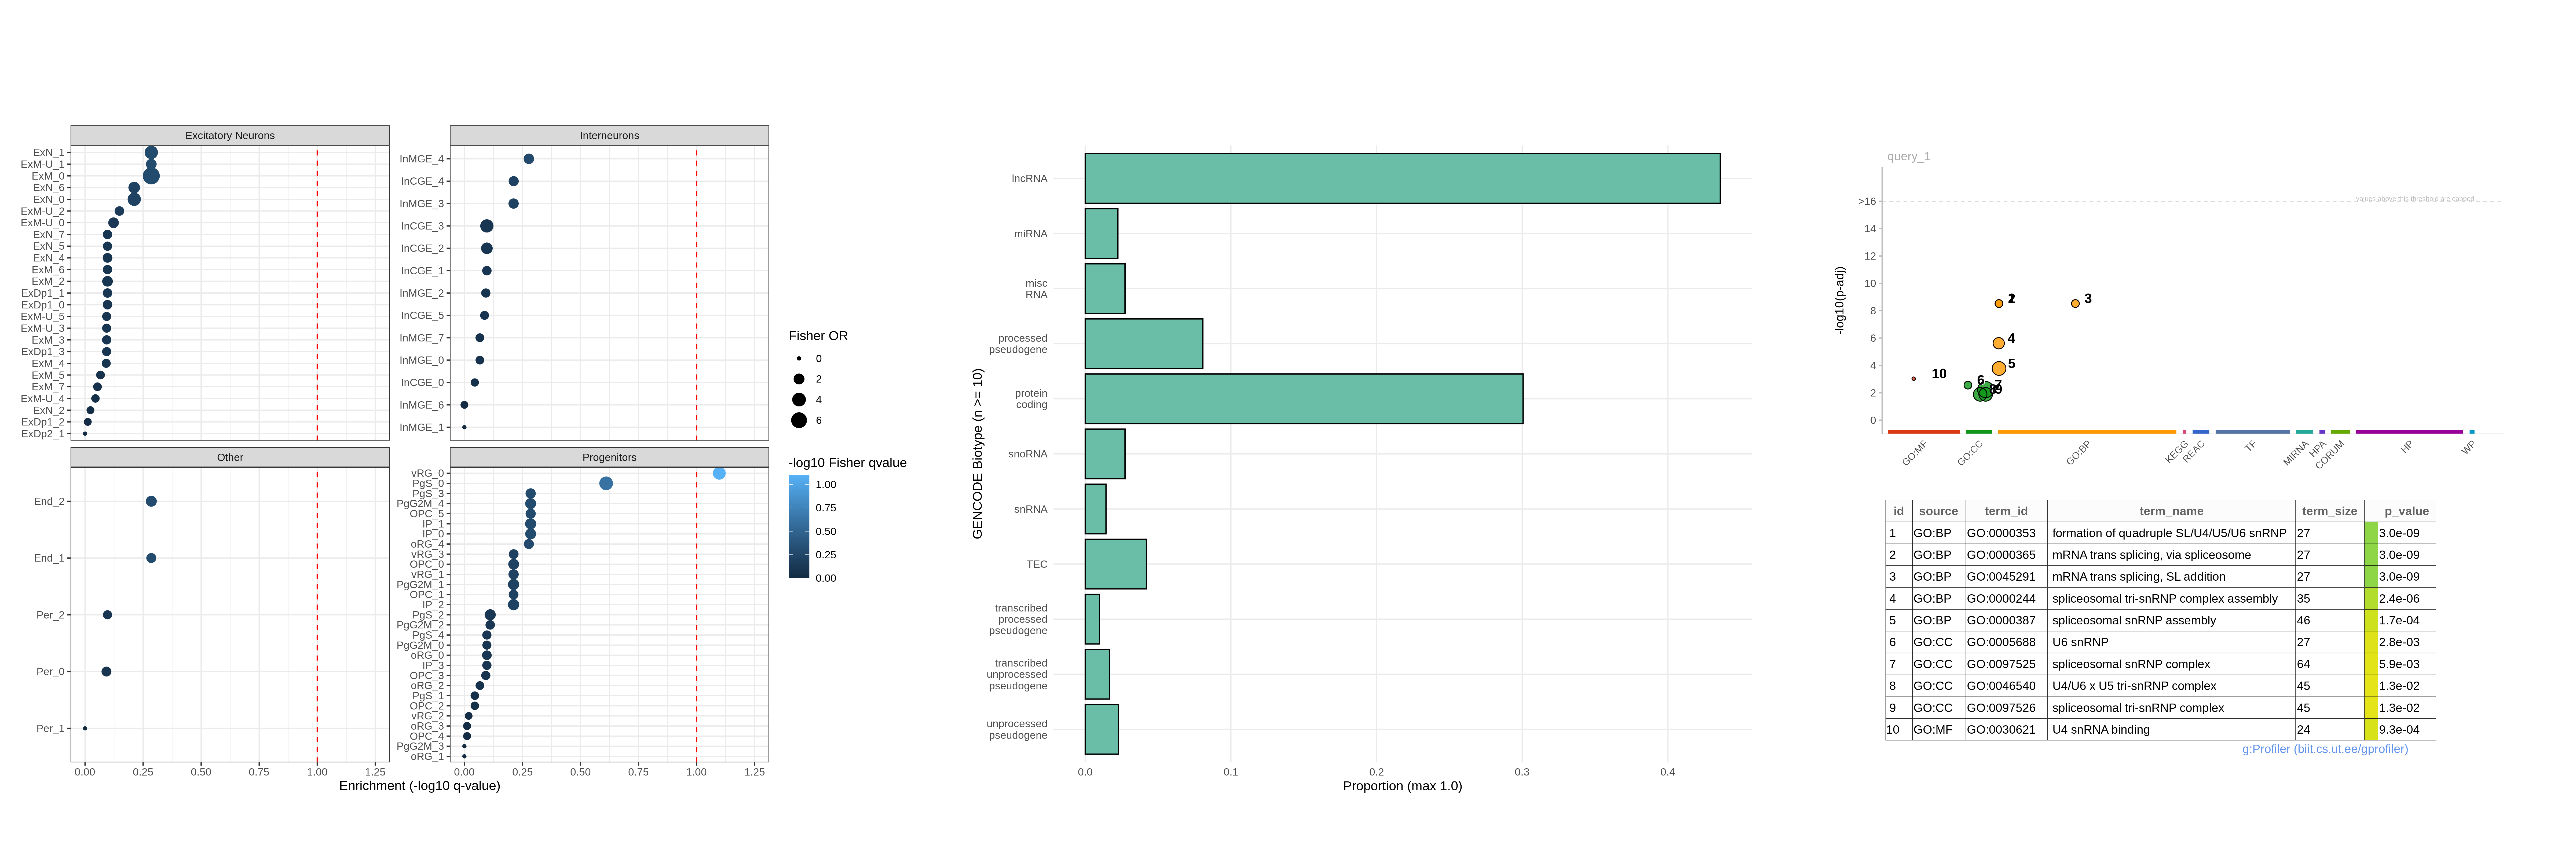

In [14]:
# Custom plot options
options(repr.plot.width = 30, repr.plot.height = 10, repr.plot.res = 320)

patch_plot <- cell_plot + theme(plot.margin = unit(c(0,50,0,0), "pt")) +
              biotype_plot + theme(plot.margin = unit(c(0,50,0,0), "pt")) +
              pubplot

patch_plot